# TODO

- Clean up code
  - Function for plotting
  - Better setup for indexing
- Add math 

$$
\begin{bmatrix}
x \\
y \\
\end{bmatrix}
$$

$$
\begin{bmatrix}
x \\
0 \\
0 \\
y \\
\end{bmatrix}
$$

$$
\begin{bmatrix}
I   & 0   & 0   & 0 \\
f_1 & 0   & 0   & 0 \\
0   & f_2 & 0   & 0 \\
0   & 0   & f_3 & 0 \\
\end{bmatrix}
$$


# Load data

In [1]:
import torch
import pandas as pd
import matplotlib.pyplot as plt
%matplotlib widget

from iterativennsimple.Sequential2D import Sequential2D, Identity
from iterativennsimple.Sequential1D import Sequential1D


In [2]:
# Turn a pandas dataframe into a pytorch tensor
def df_to_tensor(df):
    return torch.tensor(df.values, dtype=torch.float32)

In [3]:
name = 'regression_line'
#name = 'pca_line'
#name = 'circle'
#name = 'regression_circle'
#name = 'MNIST'

# Read the start data
z_start = pd.read_parquet(f'../data/processed/{name}_start.parquet')
# Read the target data
z_target = pd.read_parquet(f'../data/processed/{name}_target.parquet')

## Data preprocessing

In [4]:
z_start_tensor = df_to_tensor(z_start)
z_target_tensor = df_to_tensor(z_target)

# compute a mask for the data where every entry in each column is the same
# this is used to remove columns that are constant
mask = (z_start_tensor == z_target_tensor).all(axis=0)
mask.shape
x_mask = mask
y_mask = ~mask

# print out the shape of the masks
print(x_mask.shape, y_mask.shape)

# print out number of true entries in each mask
print(x_mask.sum(), y_mask.sum())


torch.Size([2]) torch.Size([2])
tensor(1) tensor(1)


# MLP model

In [5]:
input_size = int(x_mask.sum())
h1_size = 20
h2_size = 20
output_size = int(y_mask.sum())

x_idx = torch.arange(0, input_size)
h_idx = torch.arange(input_size, input_size+h1_size+h2_size)
y_idx = torch.arange(input_size+h1_size+h2_size, input_size+h1_size+h2_size+output_size)

total_size = input_size + h1_size + h2_size + output_size

iterations = 3

I = Identity(in_features=input_size, out_features=input_size)
f1 = Sequential1D(torch.nn.Linear(in_features=input_size, out_features=h1_size), 
                  torch.nn.ReLU(), 
                  in_features=input_size, out_features=h1_size)
f2 = Sequential1D(torch.nn.Linear(in_features=h1_size, out_features=h2_size), 
                  torch.nn.ReLU(), 
                  in_features=h1_size,    out_features=h2_size)
f3 = torch.nn.Linear(in_features=h2_size,    out_features=output_size)    

in_features_list  = [input_size, h1_size, h2_size, output_size]
out_features_list = [input_size, h1_size, h2_size, output_size]
blocks = [[I,    None, None, None],
          [f1,   None, None, None],
          [None, f2,   None, None],
          [None, None, f3,   None]]

def transpose_blocks(blocks):
    return [[blocks[j][i] for j in range(len(blocks))] for i in range(len(blocks[0]))]

map = Sequential2D(
    in_features_list=in_features_list,
    out_features_list=out_features_list,
    blocks=transpose_blocks(blocks)
)   

In [6]:
zh_start_tensor = torch.cat((z_start_tensor[:, x_mask],
                             torch.zeros(z_start_tensor.shape[0], len(h_idx)), 
                             z_start_tensor[:, y_mask]), dim=1)
zh_target_tensor = torch.cat((z_target_tensor[:, x_mask], 
                             torch.zeros(z_target_tensor.shape[0], len(h_idx)), 
                             z_target_tensor[:, y_mask]), dim=1)

In [7]:
# a dataloader which returns a batch of start and target data
class Data(torch.utils.data.Dataset):
    def __init__(self, z_start, z_target):
        self.z_start = z_start
        self.z_target = z_target
    def __len__(self):
        return len(self.z_start)
    def __getitem__(self, idx):
        return self.z_start[idx], self.z_target[idx]
    
train_data = Data(zh_start_tensor, zh_target_tensor)
train_loader = torch.utils.data.DataLoader(train_data, batch_size=100, shuffle=True)

In [8]:
# Define the loss function and optimizer
criterion = torch.nn.MSELoss()
optimizer = torch.optim.Adam(map.parameters(), lr=0.001)

In [9]:
max_epochs = 500
# Train the model
for epoch in range(max_epochs):
    for batch_idx, (start, target) in enumerate(train_loader):
        optimizer.zero_grad()

        mapped = start

        loss = 0.0
        for i in range(iterations):
            mapped = map(mapped)

        loss = criterion(mapped[:, y_idx], target[:, y_idx])
        loss.backward()

        optimizer.step()
    if epoch % 100 == 0:
        print(f'Epoch {epoch}, Batch {batch_idx}, Loss {loss.item()}')

Epoch 0, Batch 9, Loss 0.12227628380060196
Epoch 100, Batch 9, Loss 6.54779569231323e-07
Epoch 200, Batch 9, Loss 2.6334163294450263e-07
Epoch 300, Batch 9, Loss 4.7665857039191906e-08
Epoch 400, Batch 9, Loss 2.669898524487735e-09


# Training data

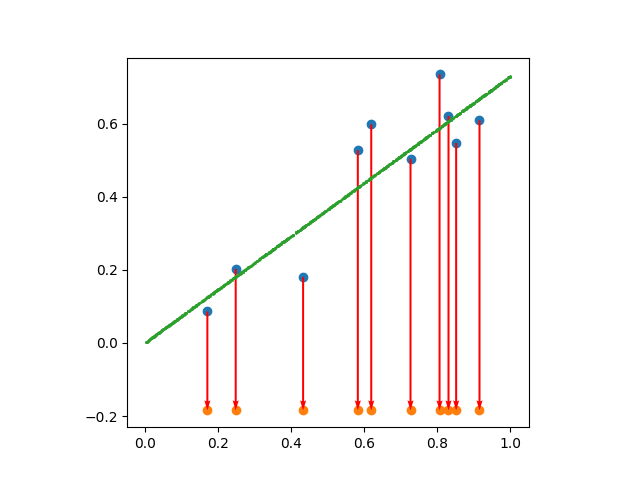

In [10]:
plot_iterations = 1

mapped_tensor = zh_start_tensor
for i in range(plot_iterations):
    mapped_tensor = map(mapped_tensor)
mapped_tensor = mapped_tensor.detach()

plot_points = 10

plt.figure()

plt.scatter(zh_start_tensor[:plot_points, x_idx], zh_start_tensor[:plot_points, y_idx])
plt.scatter(mapped_tensor[:plot_points, x_idx], mapped_tensor[:plot_points, y_idx])
dx = mapped_tensor[:plot_points, x_idx]-zh_start_tensor[:plot_points, x_idx]
dy = mapped_tensor[:plot_points, y_idx]-zh_start_tensor[:plot_points, y_idx]
plt.quiver(zh_start_tensor[:plot_points, x_idx], zh_start_tensor[:plot_points, y_idx], dx, dy, scale=1, scale_units='xy', angles='xy', color='r', width=0.005)

plt.scatter(zh_target_tensor[:, x_idx], zh_target_tensor[:, y_idx], s=1)
plt.gca().set_aspect('equal')
plt.show()

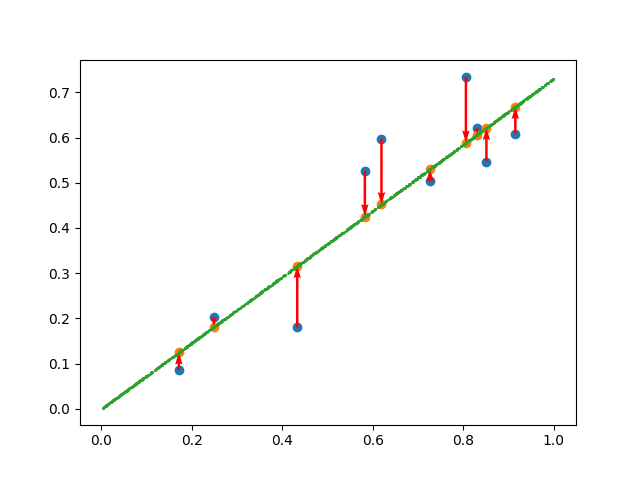

In [11]:
plot_iterations = iterations

mapped_tensor = zh_start_tensor
for i in range(plot_iterations):
    mapped_tensor = map(mapped_tensor)
mapped_tensor = mapped_tensor.detach()

plot_points = 10

plt.figure()

plt.scatter(zh_start_tensor[:plot_points, x_idx], zh_start_tensor[:plot_points, y_idx])
plt.scatter(mapped_tensor[:plot_points, x_idx], mapped_tensor[:plot_points, y_idx])
dx = mapped_tensor[:plot_points, x_idx]-zh_start_tensor[:plot_points, x_idx]
dy = mapped_tensor[:plot_points, y_idx]-zh_start_tensor[:plot_points, y_idx]
plt.quiver(zh_start_tensor[:plot_points, x_idx], zh_start_tensor[:plot_points, y_idx], dx, dy, scale=1, scale_units='xy', angles='xy', color='r', width=0.005)

plt.scatter(zh_target_tensor[:, x_idx], zh_target_tensor[:, y_idx], s=1)
plt.gca().set_aspect('equal')
plt.show()

# Path

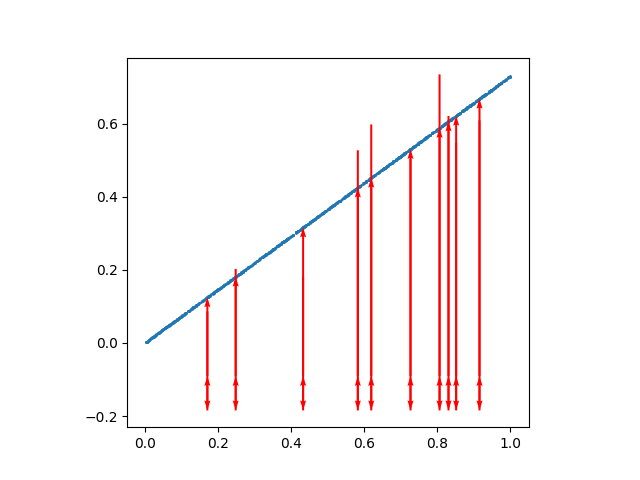

In [12]:
mapped_tensors = [zh_start_tensor]
for i in range(iterations):
    mapped_tensors.append(map(mapped_tensors[i]).detach())

plot_points = 10

plt.figure()

plt.scatter(zh_target_tensor[:, x_idx], zh_target_tensor[:, y_idx], s=1)
for i, mapped_tensor in enumerate(mapped_tensors):
    if i > 0:
        start = mapped_tensors[i-1]
        target = mapped_tensors[i]
        dx = target[:plot_points, x_idx]-start[:plot_points, x_idx]
        dy = target[:plot_points, y_idx]-start[:plot_points, y_idx]
        plt.quiver(start[:plot_points, x_idx], start[:plot_points, y_idx], dx, dy, scale=1, scale_units='xy', angles='xy', color='r', width=0.005)

plt.gca().set_aspect('equal')
plt.show()

# Testing data

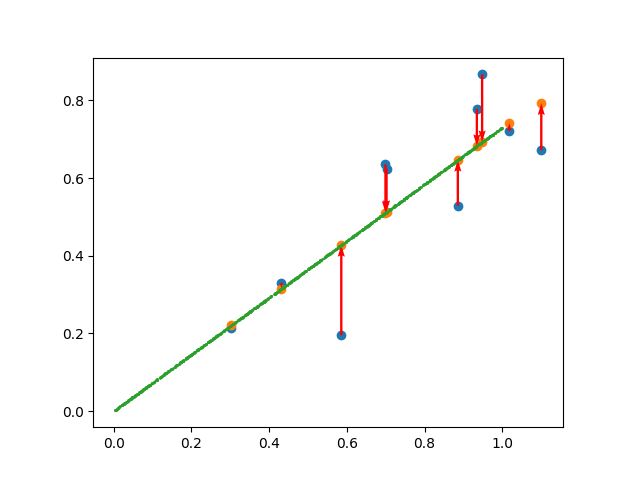

In [13]:
zh_start_tensor_test = zh_start_tensor+torch.rand_like(zh_start_tensor)*0.2
mapped_tensor = zh_start_tensor_test
for i in range(iterations):
    mapped_tensor = map(mapped_tensor)
mapped_tensor = mapped_tensor.detach()

plot_points = 10

plt.figure()

plt.scatter(zh_start_tensor_test[:plot_points, x_idx], 
            zh_start_tensor_test[:plot_points, y_idx])
plt.scatter(mapped_tensor[:plot_points, x_idx], mapped_tensor[:plot_points, y_idx])
dx = mapped_tensor[:plot_points, x_idx]-zh_start_tensor_test[:plot_points, x_idx]
dy = mapped_tensor[:plot_points, y_idx]-zh_start_tensor_test[:plot_points, y_idx]
plt.quiver(zh_start_tensor_test[:plot_points, x_idx], 
           zh_start_tensor_test[:plot_points, y_idx], 
           dx, dy, scale=1, scale_units='xy', angles='xy', color='r', width=0.005)

plt.scatter(zh_target_tensor[:, x_idx], zh_target_tensor[:, y_idx], s=1)
plt.gca().set_aspect('equal')
plt.show()